In [1]:
# Core 
import datetime
import os
import glob
import tempfile
import shutil
import sys
import pickle
import warnings
import copy

# Analysis 
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sp
import networkx 
from networkx.algorithms.components.connected import connected_components

# Plotting
import matplotlib.pyplot as plt

# Debugging 
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
from tint import animate

# CPOL convenience functions
import CPOL_func as cf


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [ ]:
def test():
    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-10 10:00'), 
        np.datetime64('2006-02-10 14:00'), 
        np.timedelta64(10, 'm')))
    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl', 'rb') as f:
        b_ind_set = pickle.load(f)

    # Define settings for tracking
    settings = {
        'MIN_SIZE' : [2, 2, 500, 500],
        'FIELD_THRESH' : [40, 30, 20, 15],
        'ISO_THRESH' : [5, 5, 5, 5],
        'GS_ALT' : 1500,
        'SEARCH_MARGIN' : 10000,
        'FLOW_MARGIN' : 40000,
        'LEVELS' : np.array(
            [[0, 2500], 
             [2500, 5000],
             [5000, 7500],
             [7500, 10000]]
        ),
        'TRACK_INTERVAL' : 0,
        'BOUNDARY_GRID_CELLS' : b_ind_set
    }

    # Calculate high and low level tracks
    tracks_obj  = tint.Cell_tracks()

    for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                      'TRACK_INTERVAL', 'ISO_THRESH', 'SEARCH_MARGIN',
                      'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS'
                     ]:
        tracks_obj.params[parameter] = settings[parameter]

    # Calculate tracks
    tracks_obj.get_tracks(grids)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                     + 'tracks_obj_test.pkl'.format(dt))

    with open(out_file_name, 'wb') as f:
        pickle.dump(tracks_obj, f)
        
    return tracks_obj
        
if __name__ == '__main__':
    try:
        tracks_obj = test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

In [2]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_test.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [5]:
try:
    tracks_obj.system_tracks.xs('0', level='uid').xs(0, level='scan')['updrafts'].values[0]
except:
    test = 0

Gathering files.
Animating 11 frames
Current grid at 2006-02-10T10:30:09.
Object initialises at 2006-02-10 10:00:09.
Moving to next object frame.
Current grid at 2006-02-10T10:30:09.
Object initialises at 2006-02-10 10:10:10.
Moving to next object frame.
Current grid at 2006-02-10T10:30:09.
Object initialises at 2006-02-10 10:20:09.
Moving to next object frame.
Plotting frame at 2006-02-10T10:30:09


Traceback (most recent call last):
  File "<ipython-input-3-c65fc3a0a1f6>", line 26, in <module>
    test()
  File "<ipython-input-3-c65fc3a0a1f6>", line 22, in test
    alt_low=0, alt_high=10000, keep_frames=False, dpi=100)
  File "/home/563/esh563/TINT/tint/visualization.py", line 777, in animate
    **kwargs)
  File "/home/563/esh563/TINT/tint/visualization.py", line 591, in updraft_view
    ax=ax, projection=projection)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/pyart/graph/gridmapdisplay.py", line 207, in plot_grid
    ds = self.get_dataset()
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/pyart/graph/gridmapdisplay.py", line 119, in get_dataset
    ds[field] = data
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/xarray/core/dataset.py", line 1077, in __setitem__
    self.update({key: value})
  File "/g/data3/hh5/public/apps/miniconda3/envs/an

> /g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/xarray/core/common.py(193)__setattr__()
-> object.__setattr__(self, name, value)
(Pdb) q


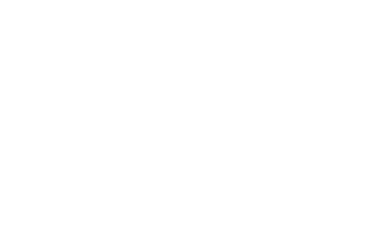

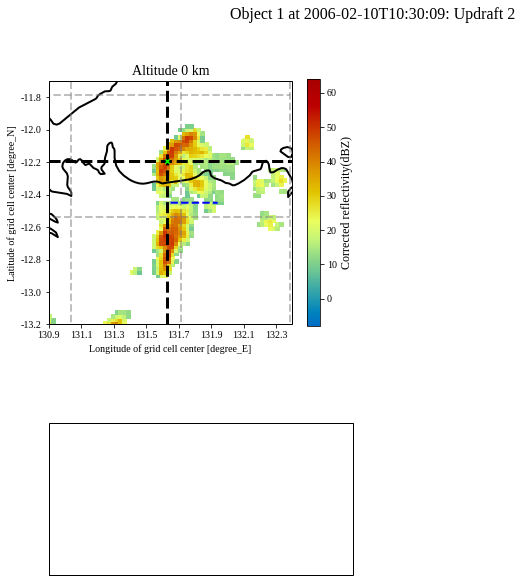

In [3]:
def test():
    uid = '1'

#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(tracks_obj, uid)
    
    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-10 10:30'), 
        np.datetime64('2006-02-10 10:40'), 
        np.timedelta64(10, 'm')))

    grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_lagrangian'
    animate(tracks_obj, grids, out_path, style='updraft', uid=uid, 
            alt_low=0, alt_high=10000, keep_frames=False, dpi=100)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

In [ ]:
lon_min = 131.0 - 1.6
lon_max = 131.0 + 1.6

lat_max = -12.2 + 1.6
lat_min = -12.2 - 1.6

[filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(np.arange(np.datetime64('2006-02-10 10:00'), 
                                                                  np.datetime64('2006-02-10 12:00'), 
                                                                  np.timedelta64(10, 'm')))

# filenames, start_time, end_time = CPOL_files_from_TINT_obj(tracks_obj, '1733')

# Generate grid generator 
# Note generators produce iterators
# These are alternative to using lists and looping
grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
         for fn in filenames)

# Create directory for figures
dt=str(datetime.datetime.now())[0:-7]
dt=dt.replace(" ", "_")
dt=dt.replace(":", "_")
dt=dt.replace("-", "")

base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
out_path = base_path + dt + '_tint_CPOL_anim'

animate(tracks_obj, grids, out_path,
        start_datetime = start_time,
        end_datetime = end_time,
        lat_lines=np.arange(lat_min, lat_max, .2),
        lon_lines=np.arange(lon_min, lon_max, .2),
        tracers=True, keep_frames=False, dpi=100, alt_low=1500,
        alt_high=9500)

In [9]:
# Let's filter by tilt direction and magnitude, velocity magnitude
# and significant area.
forward_tilt = ((-45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 45))
backward_tilt = ((-135 >= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                | (tracks_obj.system_tracks['sys_rel_tilt_dir'] >= 135))
left_tilt = ((45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 135))
right_tilt = ((-135 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= -45))
sig_tilt_mag = (tracks_obj.system_tracks['tilt_mag'] >= 2000)
vel_mag = np.sqrt(tracks_obj.system_tracks['u']**2 
                  + tracks_obj.system_tracks['v']**2)
sig_vel_mag = ((vel_mag >= 5) & (vel_mag <= 40))
eccentricity_mag = tracks_obj.system_tracks['eccentricity'] > .95
# Note for CPOL 2.5 km, total scan area is only 66052 km^2. This makes 
# traditional MCS definitions of area > 30000 km^2 difficult to apply, 
# and still coherently calculate tilt. 
sig_area = ((tracks_obj.system_tracks['proj_area'] >= 5000) & 
            (tracks_obj.system_tracks['proj_area'] <= 50000))
not_border = (tracks_obj.system_tracks['touch_border']*6.25 / tracks_obj.system_tracks['proj_area']) < 0.01

tracks_0 = tracks_obj.tracks[['touch_border', 'proj_area']].xs(
    0, level='level'
)
not_border_0 = (tracks_0['touch_border'] * 6.25 / tracks_0['proj_area']) < 0.01

In [18]:
# Let's find the cells that were tracked for the most frames.
sub_cond = sig_tilt_mag & sig_vel_mag & sig_area & not_border & not_border_0
tracks_obj.system_tracks[sub_cond].groupby(level='uid').size().sort_values(ascending=False)[:20]

uid
1733    37
6403    31
5156    29
282     27
3439    27
5261    22
1968    22
318     22
6607    21
963     21
3542    21
6386    19
2362    19
2247    19
2359    18
1403    18
5258    17
854     17
350     16
1352    16
dtype: int64

In [12]:
tracks_obj.system_tracks[sub_cond].xs('963', level='uid')[['eccentricity', 'touch_border', 'proj_area', 'sys_rel_tilt_dir']]

,,eccentricity,touch_border,proj_area,sys_rel_tilt_dir
scan,time,,,,
9647,2005-02-01 18:20:08,0.977,11,9481.25,13.992
9662,2005-02-01 20:50:08,0.957,11,15887.50,4.254
9663,2005-02-01 21:00:09,0.956,15,15906.25,-7.155
9664,2005-02-01 21:10:15,0.961,13,15518.75,9.503


# Calculate Some Statistics

In [15]:
subset_logic = sig_area & not_border & sig_vel_mag & sig_tilt_mag & not_border_0

sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]

max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS] = [np.zeros(60) for i in range(3)]

for i in sub_uids:
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']

    forward_tilt = ((-45 <= tilts) & (tilts <= 45))
    backward_tilt = ((-135 >= tilts) | (tilts >= 135))

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    TS[bwd_inds] += 1
    LS[fwd_inds] += 1
    PS[pll_inds] += 1

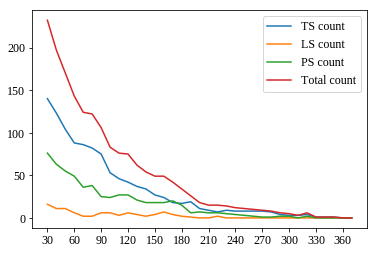

In [16]:
plt.plot(np.arange(30,380,10), TS[3:38], label='TS count')
plt.plot(np.arange(30,380,10), LS[3:38], label='LS count')
plt.plot(np.arange(30,380,10), PS[3:38], label='PS count')
plt.plot(np.arange(30,380,10), (TS+PS+LS)[3:38], label='Total count')
plt.xticks(np.arange(30,380,30))
plt.legend()

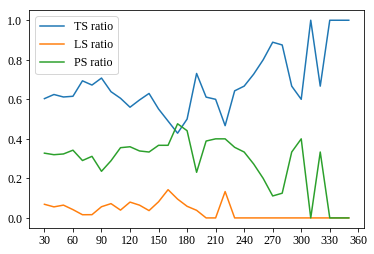

In [17]:
tot = (TS+PS+LS)

plt.plot(np.arange(30,380,10), (TS/tot)[3:38], label='TS ratio')
plt.plot(np.arange(30,380,10), (LS/tot)[3:38], label='LS ratio')
plt.plot(np.arange(30,380,10), (PS/tot)[3:38], label='PS ratio')
# plt.plot(np.arange(30,380,10), (TS+PS+LS)[3:38], label='Total')
plt.xticks(np.arange(30,380,30))
plt.legend()
# Note that we don't really know the start times of the systems!